In [1]:
# importing module
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from myutils import *
from SLBQP import SLBQP
from datastorer import DataStorer
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
params = {
    'figure.figsize': (20, 10),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

# Multiple plots

In [2]:
#roots = "C_C1EPS01,E_C1EPS001,C_C01EPS01,C_C2EPS01,E_C1EPS01,C_C05EPS01,C_C5EPS01,E_C1EPS1".split(",")
#for rootdir in roots:
#    for size in range(100, 700, 100):
#        for alg in ['GOLD', 'ROS']:
#            for n in range(10,20):
#                path = f"{rootdir}/{size}/{alg}{n}.csv"
#                #print(path)

# Inizio esperimenti seri

In [2]:
def extract_optimal_values(size):
    """reads the file containing the optimal values and returns an array with the values"""
    assert(size in [i*1e2 for i in range(1,11)])
    lines = None
    path = f"CSV/{size}/optimal_values.txt"
    with open(path, "r") as f:
        lines = f.readlines()
        lines = [np.float(i.strip()) for i in lines]
    return np.array(lines)

def load_problems_measure(size, measure='val', alg='goldstein', start_range=0,nproblems=20, maindir='CSV'):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"{maindir}/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values


In [3]:
rootfolders = "E_C1EPS001,E_C1EPS01,E_C1EPS1,C_C01EPS01,C_C05EPS01,C_C1EPS01,C_C2EPS01,C_C5EPS01,C_C10EPS01".split(',')
epsilons = [f for f in rootfolders if f.startswith("E")]
upperbounds = [f for f in rootfolders if f.startswith("C")]

In [4]:
upperbounds

['C_C01EPS01',
 'C_C05EPS01',
 'C_C1EPS01',
 'C_C2EPS01',
 'C_C5EPS01',
 'C_C10EPS01']

In [5]:
def load_problems(size, measure='val', alg='goldstein', start_range=0,nproblems=20, maindir='CSV'):
    """extract one column from all the csv of that size and algorithm"""
    prob = "GOLD" if (alg.lower().startswith('g')) or (type(alg) is int and alg == 1) else "ROS"
    path = f"{maindir}/{size}/{prob}/" + "{}.csv"
    problem_values = []
    for i in range(start_range, nproblems):
        filepath = path.format(str(i))
        problem_values.append(pd.read_csv(filepath, usecols=[measure]).to_numpy())
    return problem_values

In [6]:
#optimal_values = {} # dictionary indexed by problem size
#for size in [int(i*1e2) for i in range(1,15)]:
#    optimal_values[str(size)] = extract_optimal_values(size)

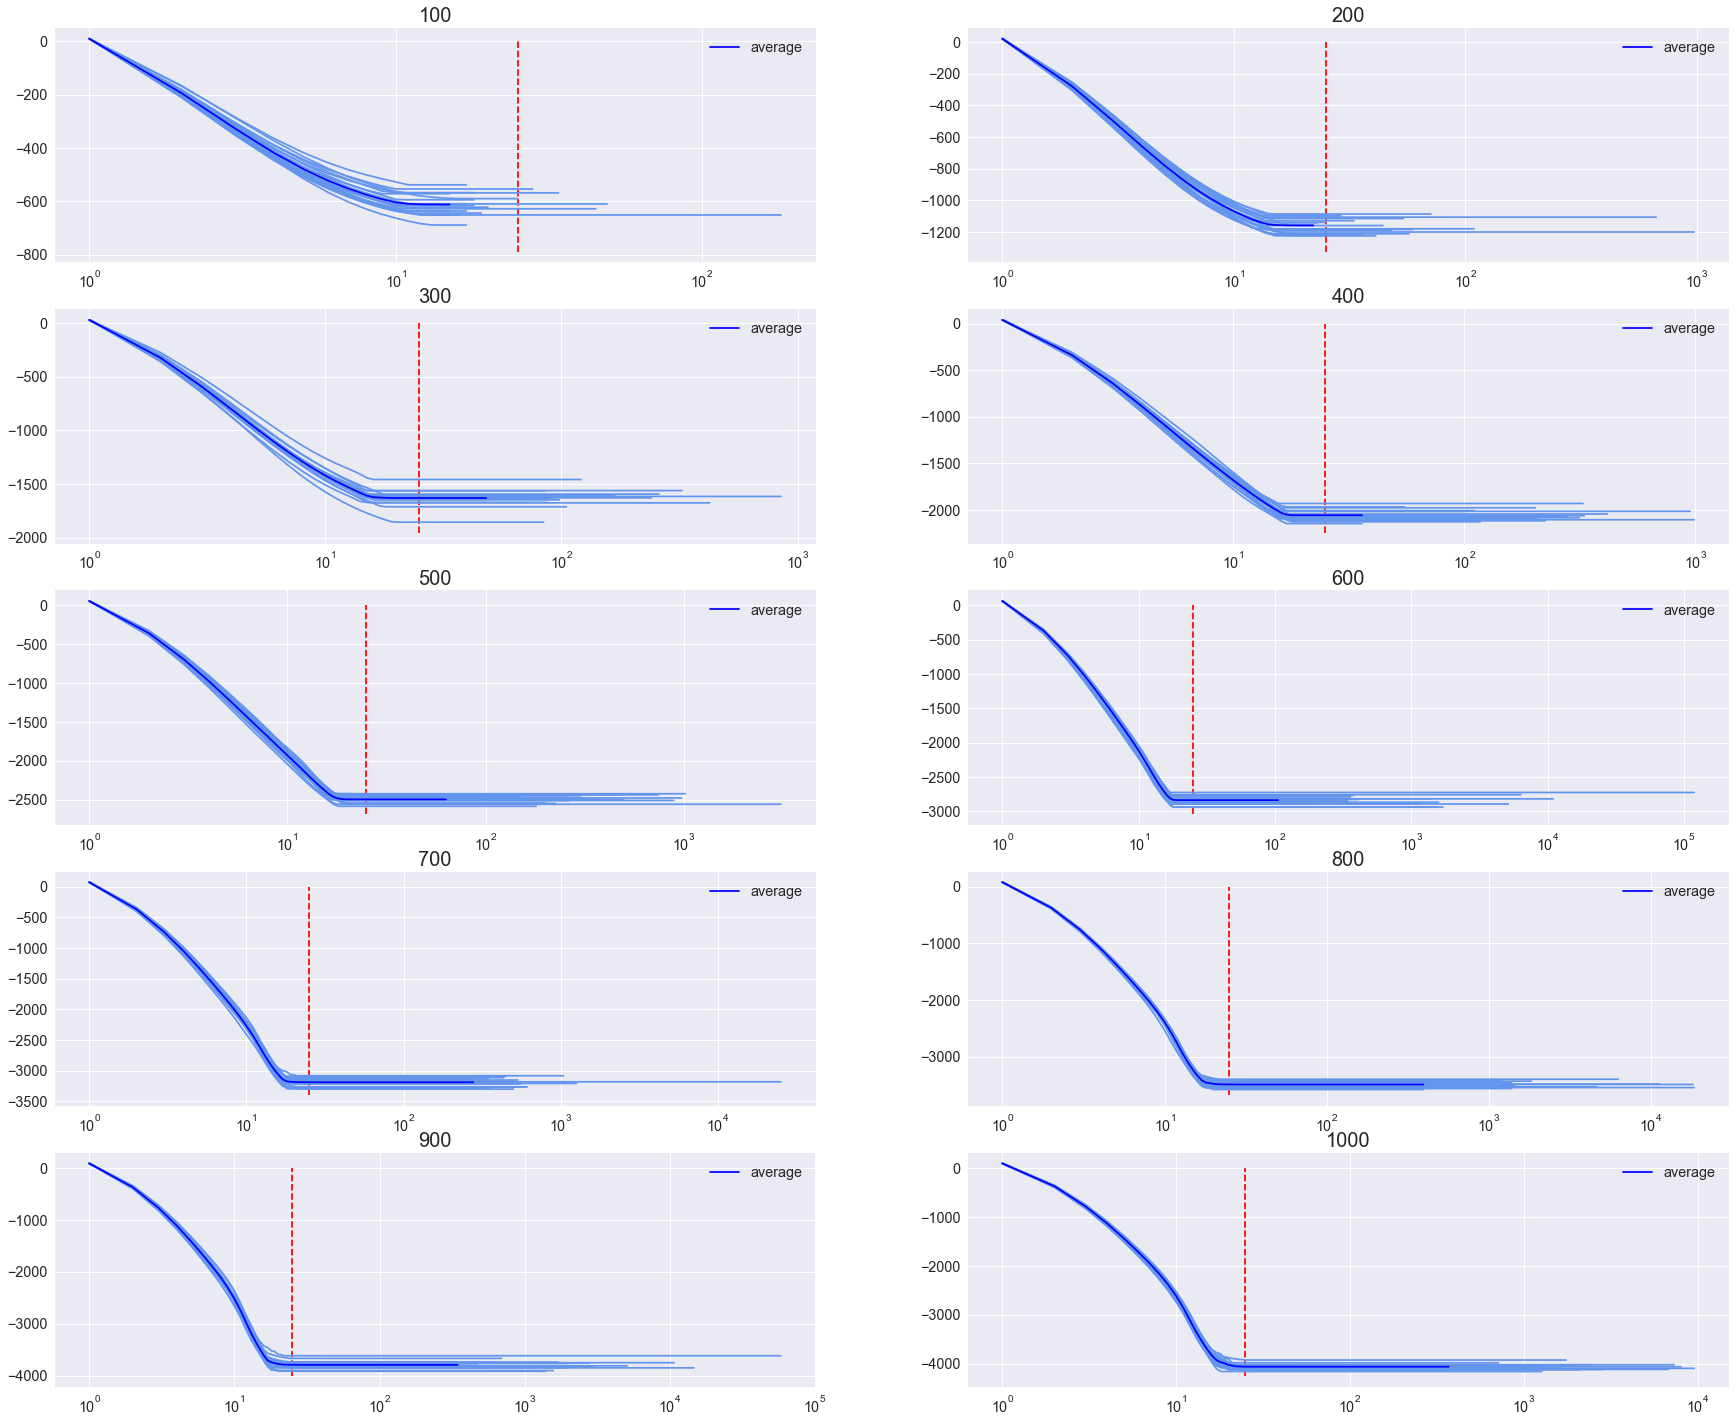

In [7]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    values = load_problems_measure(str(size))
    plot_multiple_functions(values, plot_avg=True, ax=ax)
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m = min([min(x) for x in values])
    ax.vlines(25, m-100, 0, label='25 iterations', colors='r', linestyles='dashed')

In [8]:
def transform_values(val):
    opt = val[-1]
    assert(min(val)==opt)
    return (val - opt) / np.abs(opt)

In [9]:
upperbounds

['C_C01EPS01',
 'C_C05EPS01',
 'C_C1EPS01',
 'C_C2EPS01',
 'C_C5EPS01',
 'C_C10EPS01']

# UPPERBOUNDS

In [ ]:
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(30,25), sharex=True)
sizes = [*range(100,700,100)]

for i,root in enumerate(upperbounds):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        ax.set_xscale("log") # use logaritmic scale for x
        m, M = ax.get_ylim()
        #ax.vlines(100, m-10, M+10,colors='r', linestyles='dashed')
plt.tight_layout()

In [10]:
upperbounds

['C_C01EPS01',
 'C_C05EPS01',
 'C_C1EPS01',
 'C_C2EPS01',
 'C_C5EPS01',
 'C_C10EPS01']

# ML DATASET UPPERBOUNDS

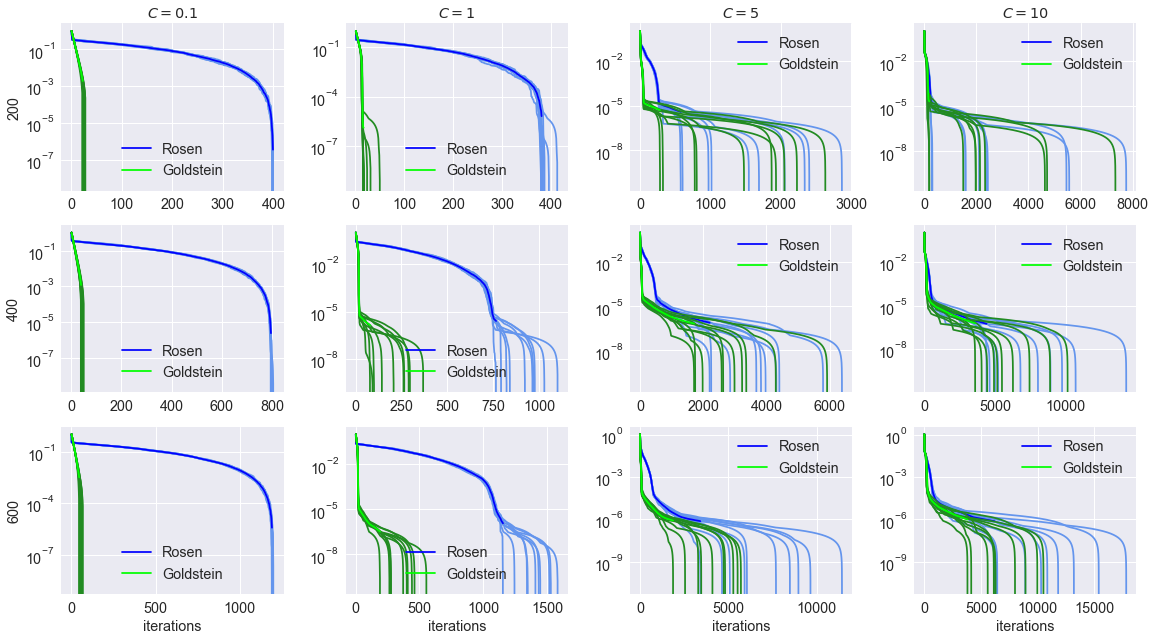

In [41]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200, 400, 600]
chosen_uppers = ['C_C01EPS01', 'C_C1EPS01','C_C5EPS01', 'C_C10EPS01']
for i,root in enumerate(chosen_uppers):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=root, nproblems=10)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=10)
        
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_yscale("symlog")
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# AIRFOIL DATASET UPPERBOUNDS

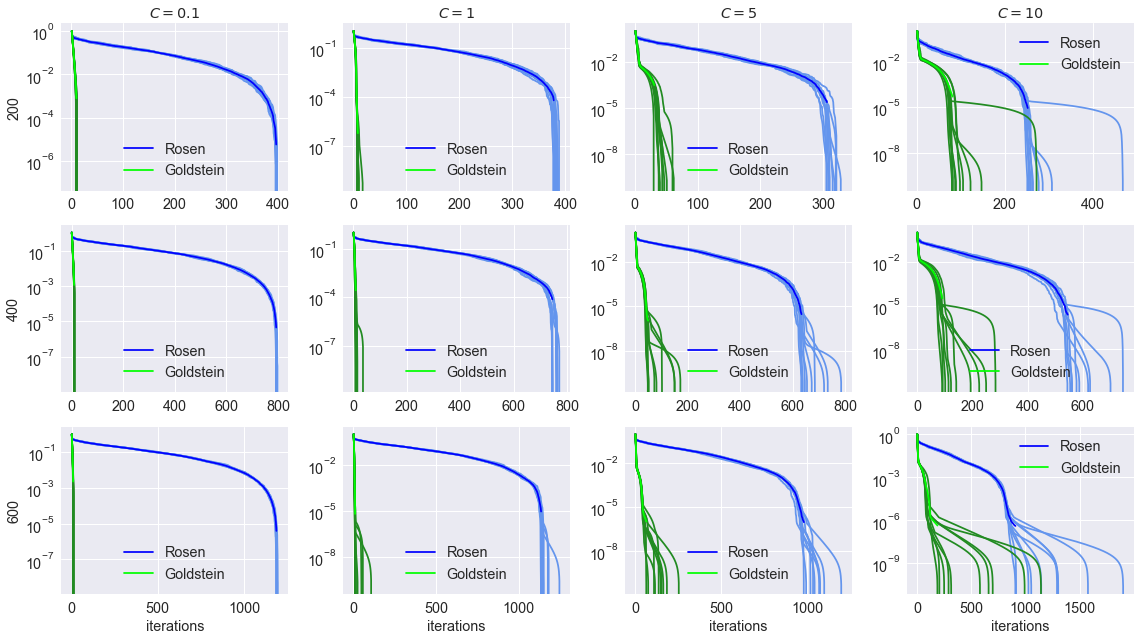

In [40]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200, 400, 600]
chosen_uppers = ['C_C01EPS01', 'C_C1EPS01','C_C5EPS01', 'C_C10EPS01']
chosen_uppers_airf = ["AIRF/"+i for i in chosen_uppers]
for i,root in enumerate(chosen_uppers_airf):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=root, nproblems=10)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=10)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        ax.set_yscale("log")
        #ax.set_xscale("log") # use logaritmic scale for x
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# AIRFOIL SEPARATED

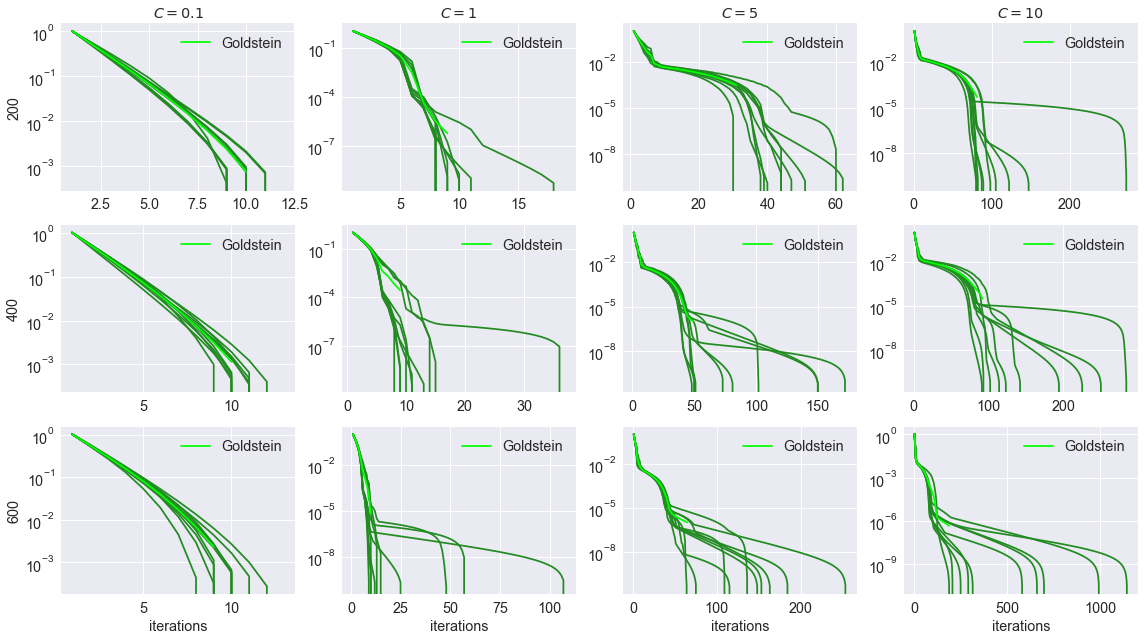

In [39]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200, 400, 600]
chosen_uppers = ['C_C01EPS01', 'C_C1EPS01','C_C5EPS01', 'C_C10EPS01']
chosen_uppers_airf = ["AIRF/"+i for i in chosen_uppers]
for i,root in enumerate(chosen_uppers_airf):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        

        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=10)
        
        
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        ax.set_yscale("log")
        #ax.set_xscale("log") # use logaritmic scale for x
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")


plt.tight_layout()

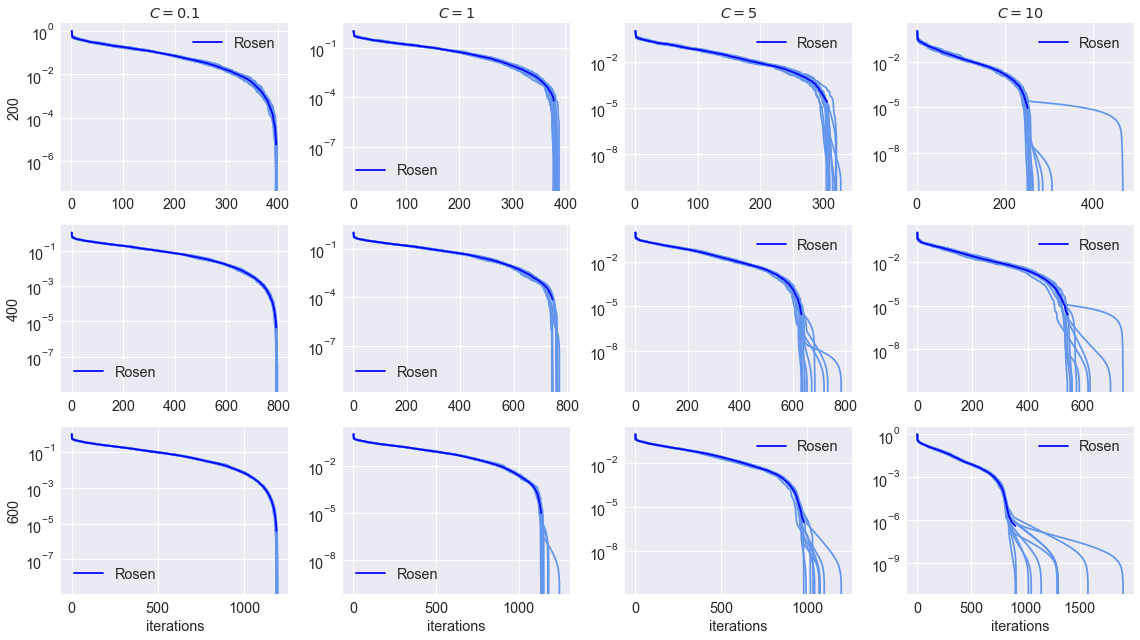

In [38]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200, 400, 600]
chosen_uppers = ['C_C01EPS01', 'C_C1EPS01','C_C5EPS01', 'C_C10EPS01']
chosen_uppers_airf = ["AIRF/"+i for i in chosen_uppers]
for i,root in enumerate(chosen_uppers_airf):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=root, nproblems=10)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        ax.set_yscale("log")
        #ax.set_xscale("log") # use logaritmic scale for x
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")



plt.tight_layout()

# CALIFORNIA HOUSING UPPEBOUNDS

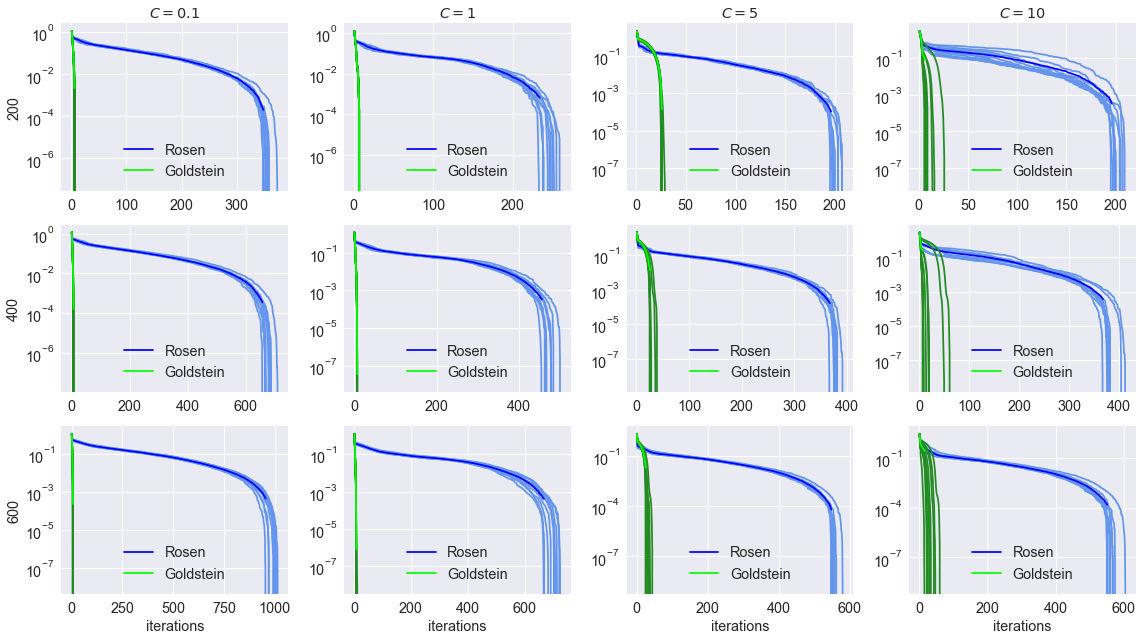

In [37]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16,9))
#sizes = [*range(100,700,100)]
sizes = [200, 400, 600]
chosen_uppers = ['C_C01EPS01', 'C_C1EPS01','C_C5EPS01', 'C_C10EPS01']
chosen_uppers_cal = ["CAL/"+i for i in chosen_uppers]
for i,root in enumerate(chosen_uppers_cal):
    for j,size in enumerate(sizes):
        ax = axs[j][i]        
        values_rosen = load_problems(str(size), alg="rosen", maindir=root, nproblems=10)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root, nproblems=10)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        ax.set_yscale("log")
        #ax.set_xscale("log") # use logaritmic scale for x
        m, M = ax.get_ylim()
        #ax.vlines(30, m-10, M+10,colors='r', linestyles='dashed')

for ax, size in zip(axs[:,0], sizes):
    ax.set_ylabel(str(size))
    

for ax, c in zip(axs[0], [0.1, 1, 5, 10]):
    ax.set_title(f"$C = {c}$")

for ax in axs[2]:
    ax.set_xlabel("iterations")


plt.tight_layout()

# EPSILONS

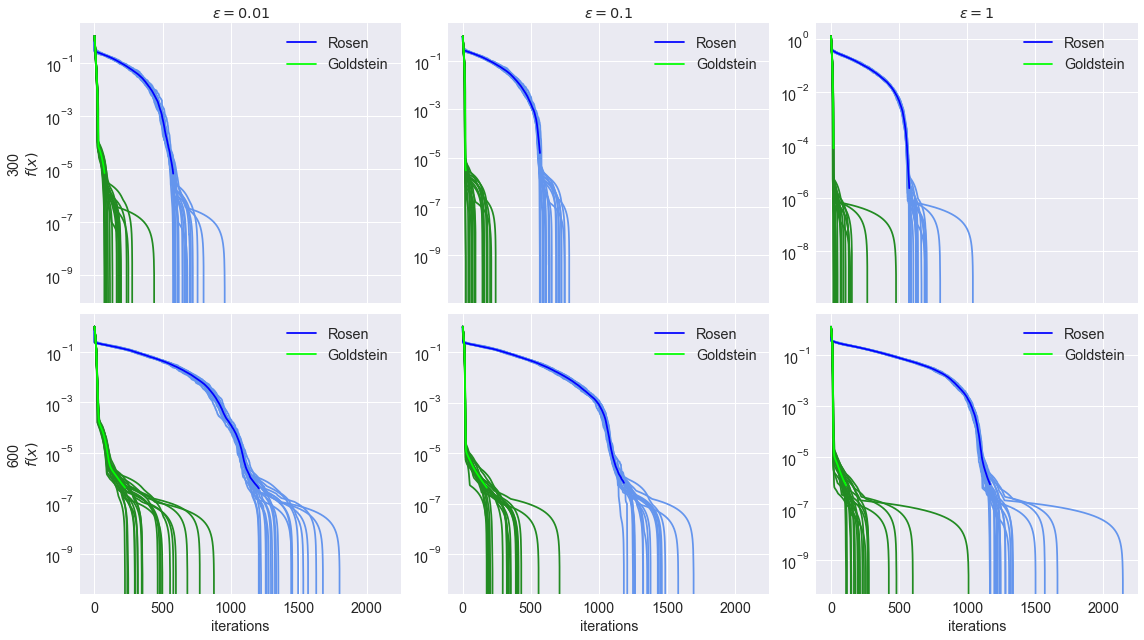

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9), sharex=True)
#sizes = [*range(100,700,100)]
sizes = [300,600]
for i,root in enumerate(epsilons):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

#for ax, size in zip(axs[:,0], sizes):
#    ax.set_ylabel(str(size)+"\n$f(x)$")
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")


#m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
#m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# EPSILONS AIRFOIL

In [26]:
epsilons

['E_C1EPS001', 'E_C1EPS01', 'E_C1EPS1']

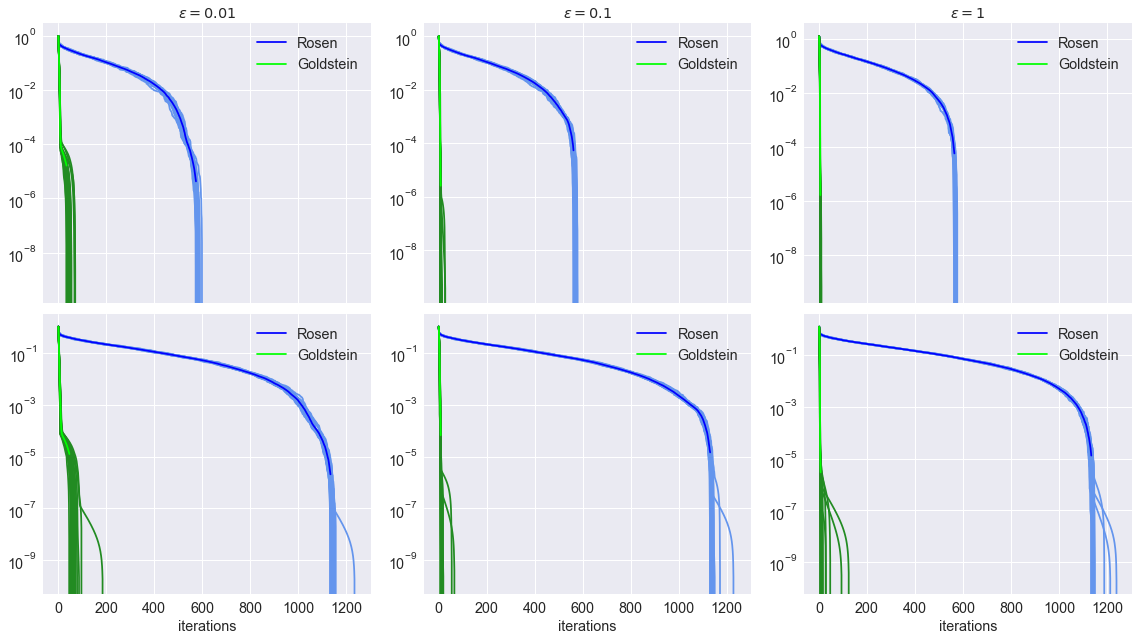

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9), sharex=True)
#sizes = [*range(100,700,100)]
sizes = [300,600]
airf_eps = ['AIRF/'+i for i in epsilons]
for i,root in enumerate(airf_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

#for ax, size in zip(axs[:,0], sizes):
#    ax.set_ylabel(str(size)+"\n$f(x)$")
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
#for ax in axs[0]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')
m, M = axs[1][0].get_ylim()
#for ax in axs[1]:
#    ax.vlines(30, m, M,colors='r', linestyles='dashed')

plt.tight_layout()

# EPSILONS CALIFORNIA

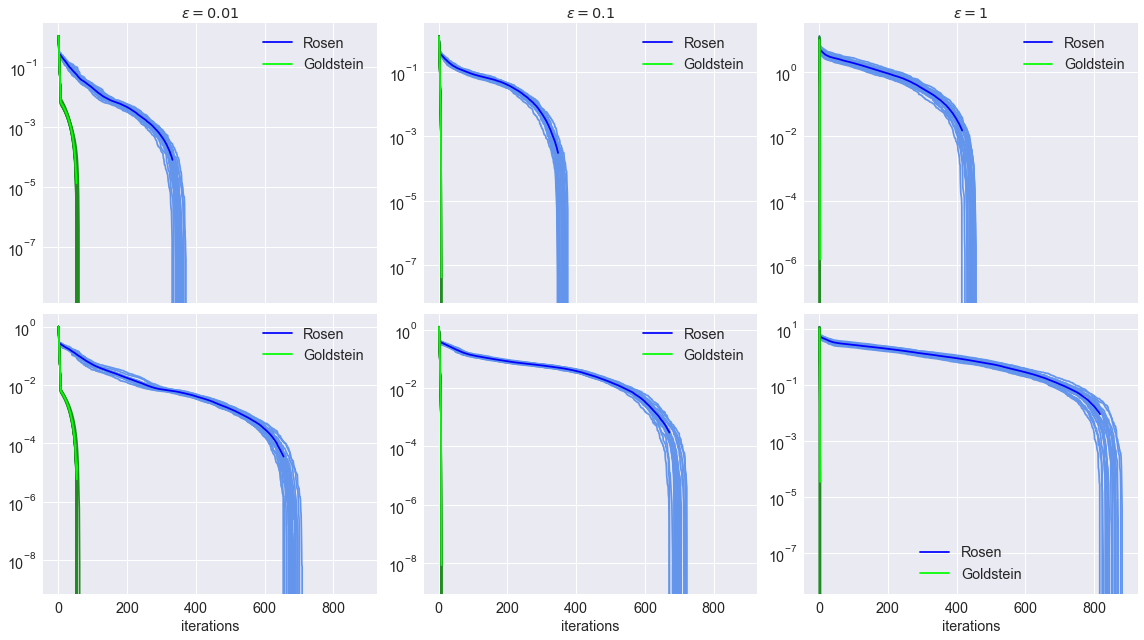

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,9), sharex=True)
#sizes = [*range(100,700,100)]
sizes = [300,600]
cal_eps = ['CAL/'+i for i in epsilons]
for i,root in enumerate(cal_eps):
    for j,size in enumerate(sizes):
        ax = axs[j][i]
        values_rosen = load_problems(str(size), alg="rosen", maindir=root)
        values_goldstein =  load_problems(str(size), alg="goldstein", maindir=root)
        
        values_rosen = [transform_values(i) for i in values_rosen]
        values_goldstein = [transform_values(i) for i in values_goldstein]
        
        plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
        plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
        #ax.set_title(str(size), fontdict={'fontsize': 15})
        #ax.set_xscale("log") # use logaritmic scale for x
        ax.set_yscale("log")
        

#for ax, size in zip(axs[:,0], sizes):
#    ax.set_ylabel(str(size)+"\n$f(x)$")
    

for ax, eps in zip(axs[0], [0.01, 0.1, 1]):
    ax.set_title(f"$\epsilon = {eps}$")

for ax in axs[1]:
    ax.set_xlabel("iterations")



m, M = axs[0][0].get_ylim()
for ax in axs[0]:
    #ax.vlines(30, m, M,colors='r', linestyles='dashed')
    pass
m, M = axs[1][0].get_ylim()
for ax in axs[1]:
    #ax.vlines(30, m, M,colors='r', linestyles='dashed')
    pass

plt.tight_layout()

# Convergenza

In [15]:
def convergence(values, optimal_values):
    tmp = values - optimal_values
    res = []
    for l in tmp:
        res.append(l[1:] / l[:-1])
    return np.array(res)

In [16]:
def plot_convergence(root, size, alg, ax=None):
    values = load_problems(str(size), alg=alg, maindir=root)
    conv = convergence(values, np.array([v[-1] for v in values]).flatten())
    if ax is None:
        plt.plot(conv)
    else:
        ax.plot(conv)

# ML DATASET

In [17]:
epsilons

['E_C1EPS001', 'E_C1EPS01', 'E_C1EPS1']

In [18]:
upperbounds

['C_C01EPS01',
 'C_C05EPS01',
 'C_C1EPS01',
 'C_C2EPS01',
 'C_C5EPS01',
 'C_C10EPS01']

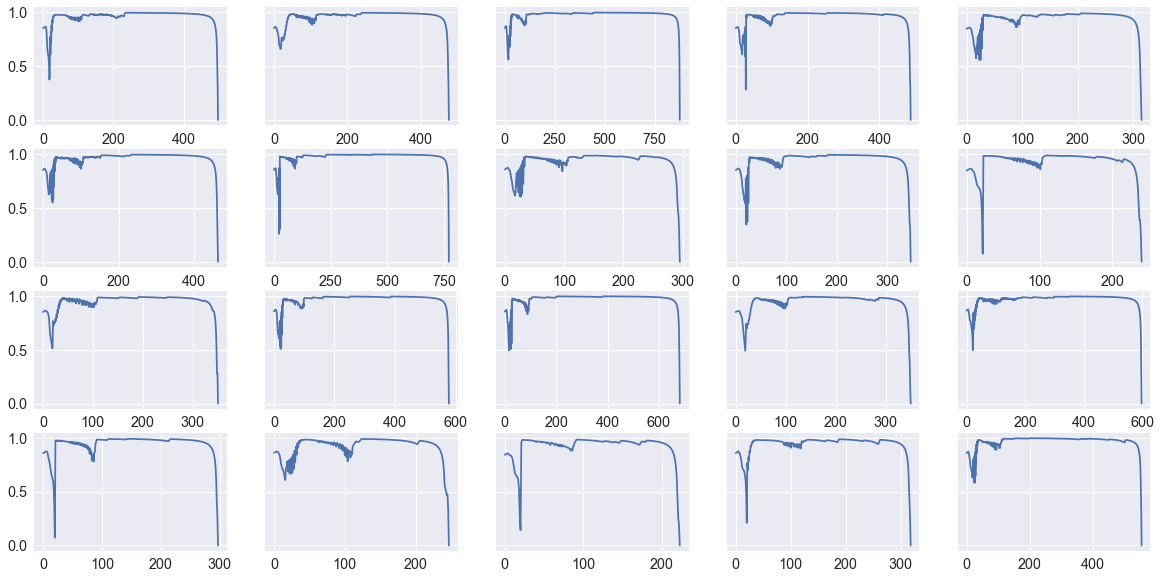

In [24]:
size=600
alg="goldstein"
maindir=epsilons[0]
values = load_problems(str(size), alg=alg, maindir=maindir)
conv = convergence(values, np.array([v[-1] for v in values]).flatten())
fig, axs = plt.subplots(4,5, sharey=True)
for (prob, ax) in zip(conv, fig.axes):
    ax.plot(prob)

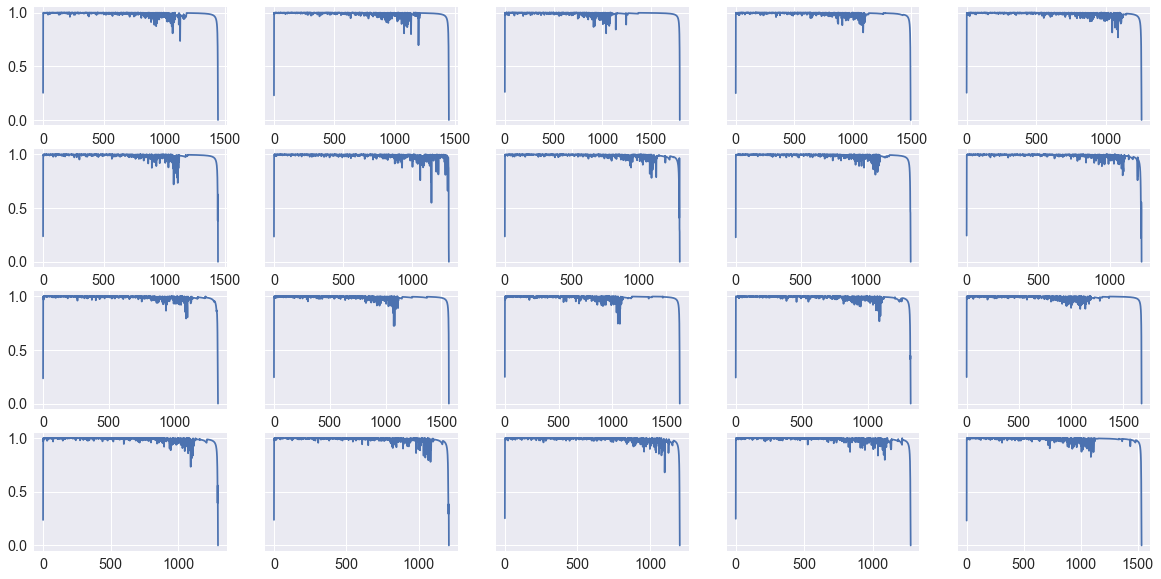

In [23]:
size=600
alg="rosen"
maindir=epsilons[0]
values = load_problems(str(size), alg=alg, maindir=maindir)
conv = convergence(values, np.array([v[-1] for v in values]).flatten())
fig, axs = plt.subplots(4,5, sharey=True)
for (prob, ax) in zip(conv, fig.axes):
    ax.plot(prob)

In [20]:
airf_eps

NameError: name 'airf_eps' is not defined

In [21]:
airf_eps

NameError: name 'airf_eps' is not defined

In [ ]:
size=600
alg="gold"
maindir=airf_eps[0]
values = load_problems(str(size), alg=alg, maindir=maindir)
conv = convergence(values, np.array([v[-1] for v in values]).flatten())

In [ ]:
print(len(conv))

In [ ]:
fig, axs = plt.subplots(4,5)
for (prob, ax) in zip(conv, fig.axes):
    ax.plot(prob)

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2)
for (problem, ax) in zip(convergence_gold_1000, fig.axes):
    ax.plot(problem)
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(ncols=3)
size = 600
for i,ax in enumerate(axs):
    plot_convergence(airf_eps[i], size, "goldstein", ax)

In [ ]:
size = 1000

In [ ]:
values_goldstein = load_problems_measure(str(size), alg="goldstein")

In [ ]:
values_rosen = load_problems_measure(str(size), alg="rosen")

In [ ]:
convergence_gold_1000 = convergence(values_goldstein, np.array([v[-1] for v in values_goldstein]).flatten())
convergence_ros_1000 = convergence(values_rosen, np.array([v[-1] for v in values_rosen]).flatten())

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2)
for (problem, ax) in zip(convergence_gold_1000, fig.axes):
    ax.plot(problem)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=2)
for (problem, ax) in zip(convergence_ros_1000, fig.axes):
    ax.plot(problem)
plt.tight_layout()

# AIRFOIL

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    if size > 600:
        break
    values_rosen = load_problems_measure(str(size), alg="rosen", maindir='AIRF', start_range=15, nproblems=25)
    values_goldstein =  load_problems_measure(str(size), alg="goldstein", maindir='AIRF', start_range=15, nproblems=25)
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")

    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m, M = ax.get_ylim()
    ax.vlines(100, m-10, M+10, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()

# California Housing

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(30,25))
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    if size > 600:
        break
    values_rosen = load_problems_measure(str(size), alg="rosen", maindir='CAL', nproblems=10)
    values_goldstein =  load_problems_measure(str(size), alg="goldstein", maindir='CAL', nproblems=10)
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")

    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m, M = ax.get_ylim()
    ax.vlines(100, m-10, M+10, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()

# C = 10 P=1e-6

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(30,25))
nproblems = 5
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    if size > 100:
        break
    values_rosen = load_problems_measure(str(size), alg="rosen", maindir='C10', nproblems=nproblems)
    values_goldstein =  load_problems_measure(str(size), alg="goldstein", maindir='C10', nproblems=nproblems)
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m, M = ax.get_ylim()
    ax.vlines(100, m-10, M+10, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(30,25))
nproblems = 5
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    if size > 400:
        break
    values_rosen = load_problems_measure(str(size), alg="rosen", maindir='C10P03EPS01', nproblems=nproblems)
    values_goldstein =  load_problems_measure(str(size), alg="goldstein", maindir='C10P03EPS01', nproblems=nproblems)
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m, M = ax.get_ylim()
    ax.vlines(100, m-10, M+10, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(30,25))
nproblems = 5
for (i, ax) in enumerate(fig.axes):
    size = int((i+1)*1e2)
    #if size > 400:
    #    break
    values_rosen = load_problems_measure(str(size), alg="rosen", maindir='C1P03EPS1', nproblems=nproblems)
    values_goldstein =  load_problems_measure(str(size), alg="goldstein", maindir='C1P03EPS1', nproblems=nproblems)
    plot_multiple_functions(values_rosen, plot_avg=True, ax=ax, label="Rosen")
    plot_multiple_functions(values_goldstein, plot_avg=True, ax=ax, color='forestgreen', col_avg='lime', label="Goldstein")
    ax.set_title(str(size), fontdict={'fontsize': 20})
    ax.set_xscale("log") # use logaritmic scale for x
    m, M = ax.get_ylim()
    ax.vlines(100, m-10, M+10, label='25 iterations', colors='r', linestyles='dashed')
plt.tight_layout()